In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib import rc
import matplotlib.colors as colors
from utils.my_plotting_lib import plot_barcodes, plot_conf_ellipse, label_axes
from utils.fim_utils import computeFimFunctional, logTransform
from toggle_model import ToggleSwitchModel
rc('text', usetex=True)

In [4]:
model = ToggleSwitchModel()
theta = np.array([model.bx,
                model.by,
                model.kx,
                model.ky,
                model.ayx,
                model.axy,
                model.nyx,
                model.nxy,
                model.gammax,
                model.gammay])
fims = {}
with np.load('results/fim_exact.npz') as _:
    fims['(x,y)'] = _["fim"]
with np.load('results/fim_marginals.npz') as _:
    fims['x'] = _['fim0']
    fims['y'] = _['fim1']
for key in fims.keys():
    logTransform(fims[key], theta)

## Compare joint vs. single-species measurements and half-and-half combination of measurement types

In [5]:
fim_mt_single_obs = {}
n_cells = 1000
max_dt = 400

batch_fims = {}
for measurement in ['(x,y)', 'x', 'y']:
    batch_fims[f"100%{measurement}"] = n_cells*fims[measurement]
batch_fims["50%x_50%y"] = (n_cells//2)*fims['x'] + (n_cells//2)*fims['y']
batch_fims["100%x_100%y"] = n_cells*fims['x'] + n_cells*fims['y']

combination_schemes = list(batch_fims.keys())

In [6]:
# D-optimality for single observation

In [7]:
d_optimality_objectives = {k: computeFimFunctional(v) for k,v in batch_fims.items()}
d_optimality_solutions = {k: np.argmax(v) for k,v in d_optimality_objectives.items()}

/var/folders/3m/mfkcqvp50y14vj21n2tcg4h80000gn/T/ipykernel_29175/3394718298.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig("figs/toggle_single_vs_half.png", dpi=300, bbox_inches="tight")
/Users/huyvo/miniforge3/envs/cme/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


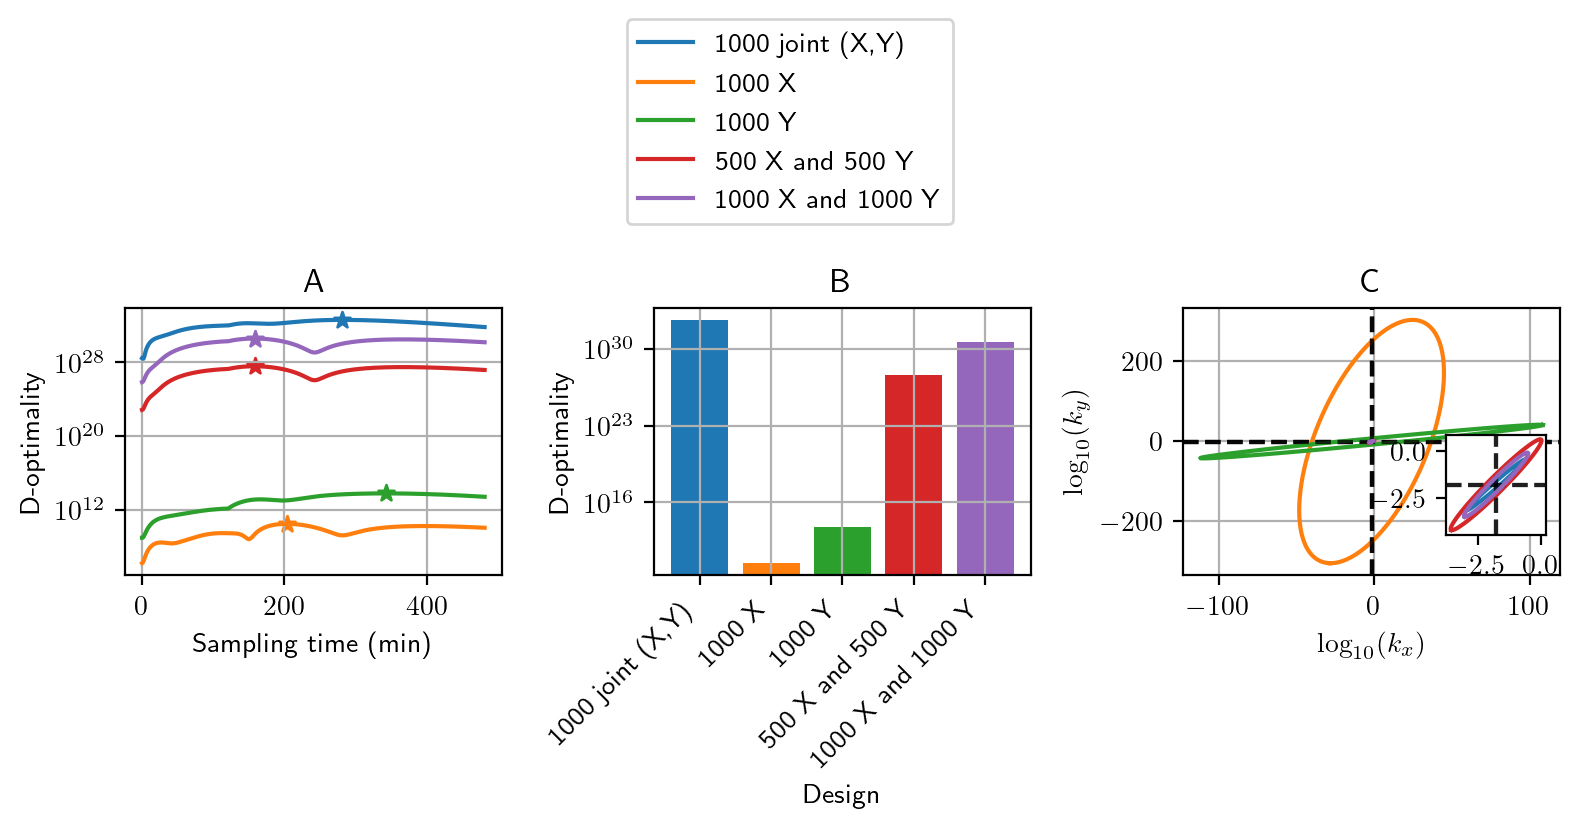

In [8]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

scheme_titles = {
    '100%(x,y)': f'{n_cells} joint (X,Y)',
    '100%x': f'{n_cells} X',
    '100%y': f'{n_cells} Y',
    '50%x_50%y': f'{n_cells//2} X and {n_cells//2} Y',
    '100%x_100%y': f'{n_cells} X and {n_cells} Y'
}

fig = plt.figure(figsize=(8, 3), dpi=200, tight_layout=True)
axs = fig.subplots(1, 3)
for ax in axs:
    ax.grid(True)

colors = {}
for design in combination_schemes:
    p = axs[0].plot(d_optimality_objectives[design], label=scheme_titles[design])
    colors[design] = p[0].get_color()
    t_opt = d_optimality_solutions[design]
    axs[0].scatter(t_opt,
                   d_optimality_objectives[design][t_opt], marker="*")
    axs[0].set_yscale("log")
axs[0].set_ylabel(r"D-optimality")
axs[0].set_xlabel(r"Sampling time (min)")


# Bar chart for the D-opt values
d_values = [d_optimality_objectives[design][d_optimality_solutions[design]] for design in combination_schemes]
exp_labels = [v for k, v in scheme_titles.items()]

for i, design in enumerate(combination_schemes):
    axs[1].bar(i, d_values[i], color=colors[design])
axs[1].set_yscale("log")
axs[1].set_xticks([0, 1, 2, 3, 4])
axs[1].set_xticklabels(exp_labels, rotation=45, ha='right')
axs[1].set_xlabel("Design")
axs[1].set_ylabel("D-optimality")


for i, design in enumerate(combination_schemes):
    t_opt = d_optimality_solutions[design]
    plot_conf_ellipse(fim=batch_fims[design][t_opt], num_sigma=3,
                       ax=axs[2], par_idx=[2, 3], theta=np.log10(theta),
                       color=colors[design])
inaxs2 = inset_axes(axs[2], width=0.5, height=0.5, loc=4, bbox_to_anchor=(0.1, 0.1, 0.9, 0.9),
                    bbox_transform=axs[2].transAxes)
for design in ["100%(x,y)", "50%x_50%y", "100%x_100%y"]:
    t_opt = d_optimality_solutions[design]
    plot_conf_ellipse(fim=batch_fims[design][t_opt], num_sigma=3,
                       ax=inaxs2, par_idx=[2, 3], theta=np.log10(theta),
                       color=colors[design])

axs[2].set_xlabel(r"$\log_{10}(k_x)$")
axs[2].set_ylabel(r"$\log_{10}(k_y)$")

h, l = axs[0].get_legend_handles_labels()
fig.legend(h, l, loc="lower center", bbox_to_anchor=(0.5, 1, 0, 0.5))
label_axes(axs)
fig.savefig("figs/toggle_single_vs_half.png", dpi=300, bbox_inches="tight")

In [9]:
import pandas as pd

lst = []
for design in combination_schemes:
    t_opt = d_optimality_solutions[design]
    lst.append(
        [scheme_titles[design],
        t_opt,
        d_optimality_objectives[design][t_opt]]
    )
df = pd.DataFrame(lst, columns=['Design', 'Optimal time (minute)', 'D-optimal information'])
df.to_csv("tables/toggle_designs.csv", index=False, float_format="%.2e")

## Joint measurement at optimal sampling time vs mixed measurements under optimal sampling period and mixture

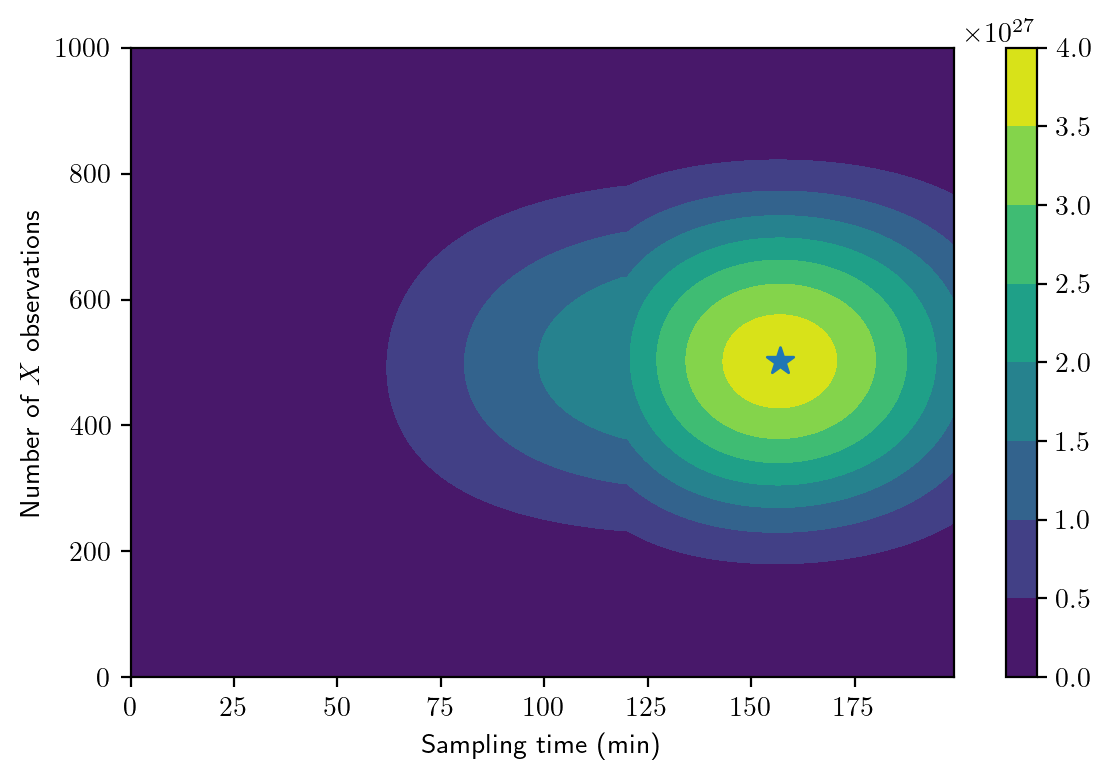

In [10]:
with np.load('results/combined_fim_dopt.npz', allow_pickle=True) as _:
    fim_opt_dt_mixture = _['fim_opt']
    nx_opt = _['nx_opt']
    dt_opt = _['dt_opt']
    fim_mixture_dets = _['fim_dets']

fig = plt.figure(dpi=200, tight_layout=True)
ax = fig.subplots(1,1)
h = ax.contourf(fim_mixture_dets)
fig.colorbar(h)
ax.set_xlabel(r'Sampling time (min)')
ax.set_ylabel(r'Number of $X$ observations')
ax.scatter(dt_opt, nx_opt, marker='*', s=100)
fig.savefig('figs/toggle_fim_mixture_dopt.png', dpi=400, bbox_inches="tight")

In [11]:
print(nx_opt)
print(dt_opt)

502
157


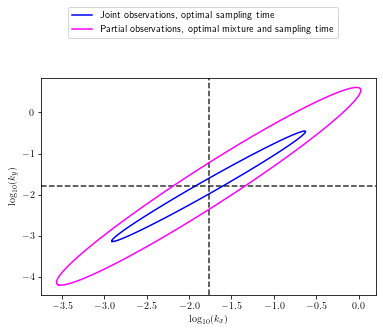

In [12]:
fig, ax = plt.subplots(1,1)
dt_opt_full = d_optimality_solutions['100%(x,y)']
fim_full = batch_fims['100%(x,y)'][dt_opt_full]
plot_conf_ellipse(fim=fim_full, num_sigma=3,
                  ax=ax, par_idx=[2, 3], theta=np.log10(theta),
                  color="blue", label=r"Joint observations, optimal sampling time")
plot_conf_ellipse(fim=fim_opt_dt_mixture, num_sigma=3,
                   ax=ax, par_idx=[2, 3], theta=np.log10(theta),
                  color="magenta", label=r"Partial observations, optimal mixture and sampling time")
ax.set_xlabel(r"$\log_{10}(k_x)$")
ax.set_ylabel(r"$\log_{10}(k_y)$")
h, l = ax.get_legend_handles_labels()
fig.legend(h, l, loc="lower center", bbox_to_anchor=(0.5, 1, 0, 0.5))
fig.savefig("figs/toggle_opt_mixture_kx_ky.png", dpi=300, bbox_inches="tight")

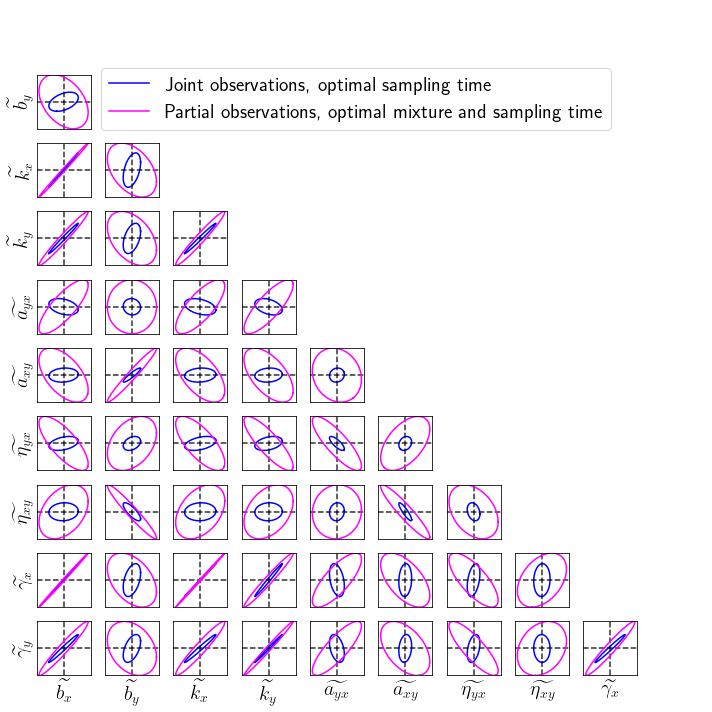

In [18]:
num_pars = model.NUM_PARAMETERS
fig = plt.figure(figsize=(10, 10), tight_layout=True)
axs = fig.subplots(num_pars, num_pars, sharex='col', sharey='row')
for i in range(num_pars):
    for j in range(i, num_pars):
        axs[i, j].axis("off")
    for j in range(0, i):
        plot_conf_ellipse(fim=fim_full,
                          num_sigma=3,
                  ax=axs[i, j], par_idx=[j, i], theta=np.log10(theta),
                  color="blue", label=r"Joint observations, optimal sampling time")
        plot_conf_ellipse(fim=fim_opt_dt_mixture, num_sigma=3,
                   ax=axs[i, j], par_idx=[j, i], theta=np.log10(theta),
                  color="magenta", label=r"Partial observations, optimal sampling time")
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].autoscale(True, tight=True)

parameter_labels=[
    r"$\widetilde{b_x}$",
    r"$\widetilde{b_y}$",
    r"$\widetilde{k_x}$",
    r"$\widetilde{k_y}$",
    r"$\widetilde{a_{yx}}$",
    r"$\widetilde{a_{xy}}$",
    r"$\widetilde{\eta_{yx}}$",
    r"$\widetilde{\eta_{xy}}$",
    r"$\widetilde{\gamma_x}$",
    r"$\widetilde{\gamma_y}$",
]

for i in range(num_pars):
    axs[i, 0].set_ylabel(parameter_labels[i], fontsize=20)
    axs[-1, i].set_xlabel(parameter_labels[i], fontsize=20)

h, l = ax.get_legend_handles_labels()
fig.legend(h, l, loc="lower center", bbox_to_anchor=(0.5, 0.8, 0, 0.5), fontsize=20)
fig.savefig("figs/toggle_conf_ellipse_opt_mixture.png", dpi=500, bbox_inches="tight")